# MIT Indoor Scene Recognition 
- Indoor scene recognition is a challenging open problem in high level vision. Most scene recognition models that work well for outdoor scenes perform poorly in the indoor domain. The main difficulty is that while some indoor scenes (e.g. corridors) can be well characterized by global spatial properties, others (e.g., bookstores) are better characterized by the objects they contain. More generally, to address the indoor scenes recognition problem we need a model that can exploit local and global discriminative information.
- We will use PyTorch for classifying the indoor scene into various categories.
- Dataset: https://www.kaggle.com/itsahmad/indoor-scenes-cvpr-2019

In [1]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

## Dataset
- There are 67 Indoor categories with a total of 15620 images. The number of images varies across categories, but there are at least 100 images per category. All images are in jpg format. 

In [2]:
!ls ../../data/indoorCVPR_09/Images

airport_inside	computerroom	     inside_subway   pantry
artstudio	concert_hall	     jewelleryshop   poolinside
auditorium	corridor	     kindergarden    prisoncell
bakery		deli		     kitchen	     restaurant
bar		dentaloffice	     laboratorywet   restaurant_kitchen
bathroom	dining_room	     laundromat      shoeshop
bedroom		elevator	     library	     stairscase
bookstore	fastfood_restaurant  livingroom      studiomusic
bowling		florist		     lobby	     subway
buffet		gameroom	     locker_room     toystore
casino		garage		     mall	     trainstation
children_room	greenhouse	     meeting_room    tv_studio
church_inside	grocerystore	     movietheater    videostore
classroom	gym		     museum	     waitingroom
cloister	hairsalon	     nursery	     warehouse
closet		hospitalroom	     office	     winecellar
clothingstore	inside_bus	     operating_room


In [4]:
data_dir = '../../data/indoorCVPR_09/Images'
classes = os.listdir(data_dir)
print(f"There are {len(classes)} classes: \n {classes}")

FileNotFoundError: [Errno 2] No such file or directory: '../data/indoorCVPR_09/Images'

## Data Transformations

In [5]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

In [10]:
# Helper function to see the image and labels
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: airport_inside (Class No: 0)


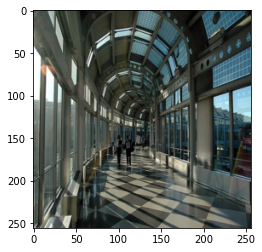

In [11]:
img, label = dataset[50]
show_sample(img, label)

## Load and Split Dataset

In [12]:
random_seed = 42
torch.manual_seed(random_seed)

In [13]:
len(dataset)

15620

In [14]:
train_set, val_set, test_set = random_split(dataset, [13000, 2000, 620])
len(train_set), len(val_set), len(test_set)

(13000, 2000, 620)

In [15]:
from torch.utils.data.dataloader import DataLoader
batch_size = 25

In [17]:
# Create training and validating dataloaders with DataLoader
train_dl = DataLoader(train_set, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_set, batch_size, num_workers = 4, pin_memory=True)

In [18]:
# Visualize batches
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
        break

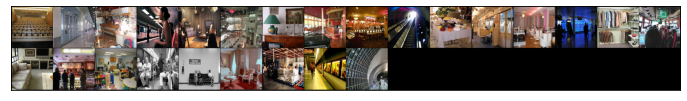

In [19]:
show_batch(train_dl)

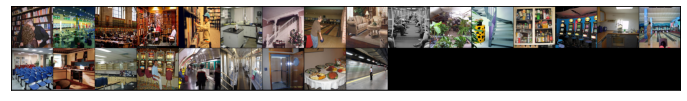

In [20]:
show_batch(val_dl)

## ResNet Model

In [21]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images) # generate predictions
        loss = F.cross_entropy(out, labels) # calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images) # generate predictions
        loss = F.cross_entropy(out, labels) # calculate loss
        acc = accuracy(out, labels) # calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [22]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # apply pretrain model
        self.network = models.resnet18(pretrained=True)
        
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
        
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [23]:
model = ResNet()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/mnguyen0226/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
52.5%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


## Choose GPU if available

In [24]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [25]:
device = get_default_device()
device

device(type='cpu')

In [26]:
# Set DataLoad to device
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

## Train Model

In [27]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [28]:
model = to_device(ResNet(), device)

In [29]:
evaluate(model, val_dl)

{'val_loss': 4.221805572509766, 'val_acc': 0.017999999225139618}

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 6e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [ ]:
evaluate(model, val_dl)

## Visualize Predictions

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [ ]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_ds[23]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))